# Universidad de Buenos Aires
# Aprendizaje Profundo - TP2
# Cohorte 20 - 3er bimestre 2025


Este segundo TP se debe entregar hasta las **23hs del domingo 17 de agosto (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP2 EQUIVALE AL 40% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/wgKVpFhX6F6Nfkf46)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

In [1]:
import gdown
import os

# Función para descargar un archivo solo si no existe
def descargar_si_no_existe(url_id, output_path):
    if not os.path.exists(output_path):
        gdown.download(url + url_id, output_path, quiet=False)

url = 'https://drive.google.com/uc?id='

### Archivos Utiles:
descargar_si_no_existe('1g6ozk5bXV-jeaqf0FnHOQWOzflhKkro0', 'requirements.txt')

In [2]:
# pip install -r requirements.txt --> En caso de no tener las librerías instaladas

In [3]:
import zipfile
import os, hashlib, random, torch
from collections import Counter, defaultdict
from PIL import Image, ImageOps, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torchinfo as torchinfo
from tqdm import tqdm

# **CLASIFICADOR DE EMOCIONES**

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/1pGsz3NFVHOfDpFG3jvpuM4NtpDCv757Z/view?usp=sharing

In [4]:
### Archivos Utiles:
zip_path = "dataset_emociones.zip"
descargar_si_no_existe('1pGsz3NFVHOfDpFG3jvpuM4NtpDCv757Z', zip_path)

In [5]:
# Ruta del ZIP descargado
output_dir = ""

# Descomprimir si no existe la carpeta destino
if not os.path.exists(output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Archivo descomprimido ")
else:
    print(f"Carpeta ya existe, no se descomprime.")

Archivo descomprimido 


In [6]:
BASE_DIR = "dataset_emociones" 
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "validation")
VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

In [7]:
def list_images_by_class(split_dir):
    class_to_paths = {}
    for cls in sorted(os.listdir(split_dir)):
        cdir = os.path.join(split_dir, cls)
        if not os.path.isdir(cdir): 
            continue
        paths = []
        for fname in os.listdir(cdir):
            ext = os.path.splitext(fname)[1].lower()
            if ext in VALID_EXTS:
                paths.append(os.path.join(cdir, fname))
        if paths:
            class_to_paths[cls] = paths
    return class_to_paths

In [8]:
train_paths = list_images_by_class(TRAIN_DIR)
val_paths   = list_images_by_class(VAL_DIR)

## 1. Preprocesamiento de Datos (2 puntos)

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.



### Análisis Exploratorio

In [9]:
# Cantidad por clase
train_counts = {c: len(p) for c, p in train_paths.items()}
val_counts   = {c: len(p) for c, p in val_paths.items()}
df_counts = pd.DataFrame({
    "class": sorted(set(train_counts)|set(val_counts))
})
df_counts["train"] = df_counts["class"].map(train_counts).fillna(0).astype(int)
df_counts["val"]   = df_counts["class"].map(val_counts).fillna(0).astype(int)
df_counts["total"] = df_counts["train"] + df_counts["val"]
display(df_counts)

,class,train,val,total
0,alegria,4772,1185,5957
1,disgusto,717,160,877
2,enojo,705,162,867
3,miedo,281,74,355
4,seriedad,2524,680,3204
5,sorpresa,1290,329,1619
6,tristeza,1982,478,2460


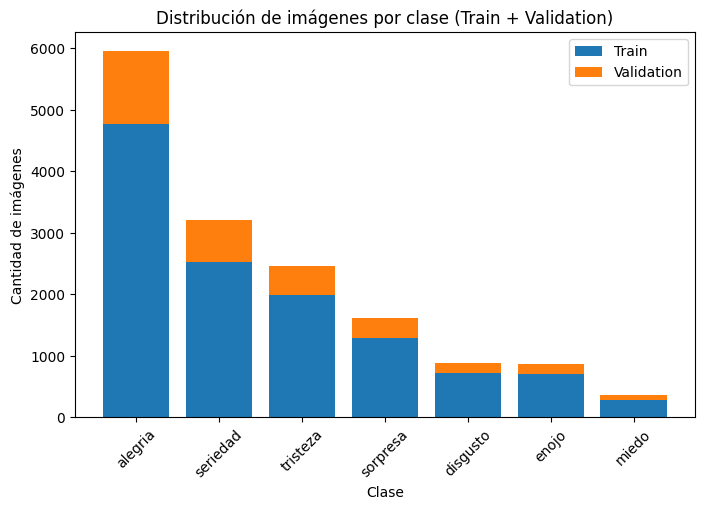

In [10]:
df_counts_sorted = df_counts.sort_values("total", ascending=False)

plt.figure(figsize=(8,5))
plt.bar(df_counts_sorted["class"], df_counts_sorted["train"], label="Train")
plt.bar(df_counts_sorted["class"], df_counts_sorted["val"],
        bottom=df_counts_sorted["train"], label="Validation")
plt.title("Distribución de imágenes por clase (Train + Validation)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.legend()
plt.show()

El dataset presenta un **fuerte desbalance** entre las clases de emociones.  
- **Alegría** es la clase más representada, con casi 6.000 imágenes, muy por encima del resto.  
- **Seriedad** y **tristeza** tienen una cantidad intermedia de ejemplos.  
- Clases como **sorpresa**, **disgusto**, **enojo** y especialmente **miedo** están significativamente subrepresentadas, con miedo siendo la clase minoritaria (menos de 500 imágenes).  

Este desbalance puede generar un **sesgo del modelo** hacia las clases mayoritarias, afectando la capacidad de generalizar en las clases menos frecuentes.  
Para mitigar este problema, se recomienda considerar técnicas como:
- **WeightedRandomSampler** o **pesos en la función de pérdida** (CrossEntropyLoss con weight).
- **Data augmentation** más intensivo para clases minoritarias.

In [11]:
# Tamaños, aspect ratio y modos
def image_summary(class_to_paths, max_images=2000):
    sizes, ars, modes = [], [], []
    for paths in class_to_paths.values():
        for p in paths[:max_images]:
            try:
                with Image.open(p) as im:
                    w, h = im.size
                    if h == 0: 
                        continue
                    sizes.append((w, h))
                    ars.append(w / h)
                    modes.append(im.mode)
            except Exception:
                pass
    return sizes, ars, modes

In [12]:
train_sizes, train_ar, train_modes = image_summary(train_paths)
val_sizes,   val_ar,   val_modes   = image_summary(val_paths)

In [13]:
def size_table(sizes, split_name):
    cnt = Counter(sizes)
    rows = [{"split": split_name, "size": f"{w}x{h}", "count": c} for (w,h), c in sorted(cnt.items())]
    return pd.DataFrame(rows)

df_sizes = pd.concat([size_table(train_sizes, "train"),
                      size_table(val_sizes,   "validation")], ignore_index=True)

In [14]:
def unique_counts(values, name):
    cnt = Counter(values)
    rows = [{"value": k, "count": v, "metric": name} for k, v in sorted(cnt.items())]
    return pd.DataFrame(rows)

df_ar    = unique_counts(train_ar + val_ar, "aspect_ratio (W/H)")
df_modes = unique_counts(train_modes + val_modes, "PIL mode")

In [15]:
display(df_sizes.sort_values(["split","size"]))
display(df_ar.sort_values("count", ascending=False))
display(df_modes.sort_values("count", ascending=False))

,split,size,count
0,train,100x100,8975
1,validation,100x100,3068


,value,count,metric
0,1.0,12043,aspect_ratio (W/H)


,value,count,metric
0,RGB,12043,PIL mode


El análisis de las dimensiones y propiedades de las imágenes del dataset muestra que:

- **Todas las imágenes** tienen exactamente **100×100 píxeles**, tanto en el conjunto de entrenamiento como en el de validación.
- El **aspect ratio** es único e igual a **1.0**, lo que confirma que todas las imágenes son **cuadradas**.
- El **modo de color** es homogéneo: todas las imágenes están en formato **RGB**.

Esto implica que **no es necesario realizar operaciones de redimensionado o recorte para unificar tamaños o proporciones**, y que el preprocesamiento puede centrarse en la normalización y en técnicas de *data augmentation* adecuadas.  

In [16]:
def build_comparison_mosaic(
        train_class_to_paths,
        val_class_to_paths,
        n_per_class=3,
        thumb=112,
        out_path="mosaic_train_val.jpg",
        margin=6,
        label_w=140,
        header_h=36,
        bg_color=(245,245,245),
        text_color=(30,30,30)
    ):
    classes = sorted(set(train_class_to_paths.keys()) | set(val_class_to_paths.keys()))
    if not classes:
        return None

    cols_each = n_per_class
    gap_between_panels = 20
    panel_w = cols_each * thumb + (cols_each + 1) * margin
    rows = len(classes)
    H = header_h + rows * thumb + (rows + 1) * margin
    W = label_w + margin + panel_w + gap_between_panels + panel_w + margin

    canvas = Image.new("RGB", (W, H), bg_color)
    draw = ImageDraw.Draw(canvas)

    try:
        font = ImageFont.truetype("Arial.ttf", 16)
        font_bold = ImageFont.truetype("Arial.ttf", 18)
    except:
        font = ImageFont.load_default()
        font_bold = ImageFont.load_default()

    def get_text_size(text, font):
        try:
            bbox = draw.textbbox((0, 0), text, font=font)
            return bbox[2] - bbox[0], bbox[3] - bbox[1]
        except AttributeError:
            return draw.textsize(text, font=font)

    def center_text_x(x0, x1, text, font):
        tw, _ = get_text_size(text, font)
        return x0 + (x1 - x0 - tw) // 2

    train_x0 = label_w + margin
    train_x1 = train_x0 + panel_w
    val_x0 = train_x1 + gap_between_panels
    val_x1 = val_x0 + panel_w

    draw.text((center_text_x(train_x0, train_x1, "TRAIN", font_bold), margin // 2),
              "TRAIN", fill=text_color, font=font_bold)
    draw.text((center_text_x(val_x0, val_x1, "VALIDATION", font_bold), margin // 2),
              "VALIDATION", fill=text_color, font=font_bold)

    def paste_strip(paths_list, start_x, y, cols):
        x = start_x + margin
        if len(paths_list) < cols and len(paths_list) > 0:
            paths_list = paths_list + random.choices(paths_list, k=cols - len(paths_list))
        for p in paths_list[:cols]:
            try:
                with Image.open(p) as im:
                    tile = ImageOps.fit(im.convert("RGB"), (thumb, thumb))
                    canvas.paste(tile, (x, y))
            except Exception:
                pass
            x += thumb + margin

    y = header_h
    for cls in classes:
        tw, th = get_text_size(cls, font)
        draw.text((max(0, label_w - tw - 8), y + (thumb - th) // 2),
                  cls, fill=text_color, font=font)

        train_paths = train_class_to_paths.get(cls, [])
        val_paths   = val_class_to_paths.get(cls, [])

        k_train = min(n_per_class, len(train_paths))
        k_val   = min(n_per_class, len(val_paths))
        sample_train = random.sample(train_paths, k_train) if k_train > 0 else []
        sample_val   = random.sample(val_paths, k_val) if k_val > 0 else []

        paste_strip(sample_train, train_x0, y + margin, cols_each)
        paste_strip(sample_val,   val_x0,   y + margin, cols_each)

        y += thumb + margin

    canvas.save(out_path)
    return out_path

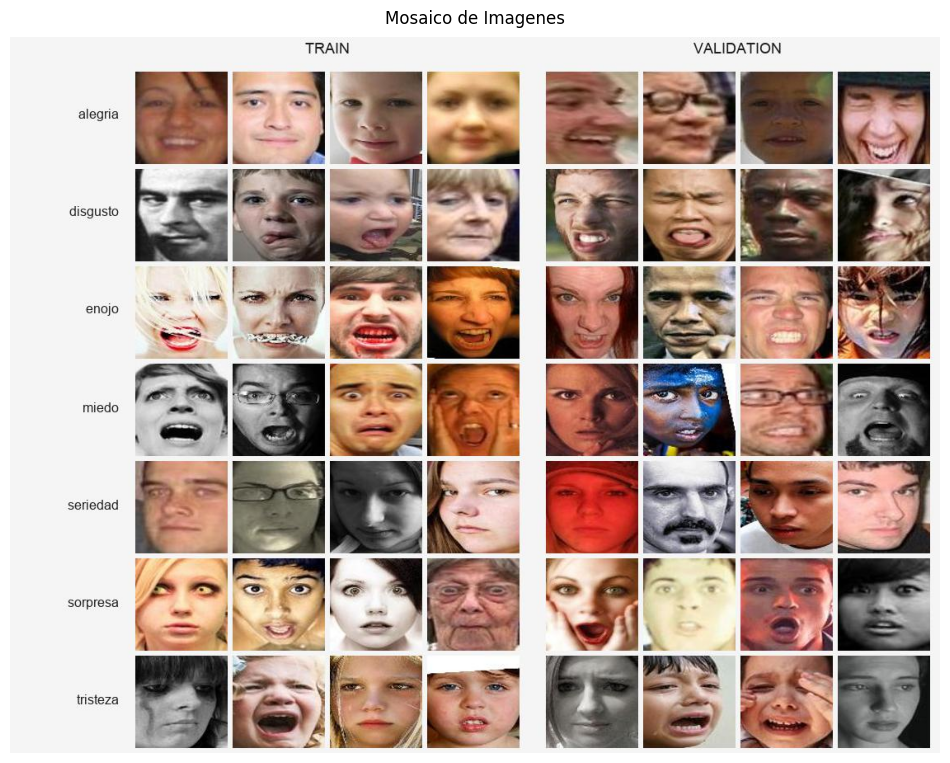

In [17]:
mosaic_path = build_comparison_mosaic(train_paths, val_paths, n_per_class=4, thumb=112)

if mosaic_path and os.path.exists(mosaic_path):
    img = Image.open(mosaic_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Mosaico de Imagenes", pad=10)
    plt.show()

La visualización comparativa entre el conjunto de entrenamiento (*Train*) y el de validación (*Validation*) permite observar:

- **Variabilidad intra-clase**: Dentro de cada emoción existe una diversidad notable en cuanto a edad, género, iluminación y ángulo de captura, lo cual es positivo para la capacidad de generalización del modelo.
- **Calidad heterogénea**: Algunas imágenes presentan desenfoque, recortes parciales o variaciones de color (RGB y escalas de grises), lo que podría requerir normalización. Dado que las expresiones se basan principalmente en textura y forma, es razonable unificar el espacio de color pasando todo a escala de grises, lo que simplifica el modelo sin perder información relevante.
- **Coherencia semántica**: Las muestras por clase son en su mayoría representativas de la emoción indicada, sin aparentes etiquetas erróneas a simple vista.

Se requiere un preprocesamiento que incluya normalización, *data augmentation* moderado y un manejo explícito del desbalance para mejorar el rendimiento del clasificador.

### Preprocesamiento

In [18]:
IMG_SIZE = 100
BATCH_SIZE = 128
NUM_WORKERS = 2
torch.manual_seed(42)

tmp_tf = transforms.Compose([transforms.Grayscale(1), transforms.ToTensor()])
train_tmp = datasets.ImageFolder(TRAIN_DIR, transform=tmp_tf)
tmp_loader = DataLoader(train_tmp, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

n = 0
s1 = torch.zeros(1)
s2 = torch.zeros(1)
for x, _ in tmp_loader:        # x: [B,1,H,W] en [0,1]
    b = x.size(0)
    n += b
    s1 += x.mean(dim=[0,2,3]) * b
    s2 += (x**2).mean(dim=[0,2,3]) * b

mean = (s1 / n)
std  = (s2 / n - (s1/n)**2).sqrt()
print("mean:", mean.tolist(), "std:", std.tolist())

mean: [0.4816209077835083] std: [0.24266886711120605]


In [19]:
# Normalización usando la media y std calculadas del set de entrenamiento
norm = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

AUG = True  # activar/desactivar data augmentation

train_tf = transforms.Compose([
    transforms.Grayscale(1),                            # convertir a escala de grises (1 canal)
    transforms.RandomHorizontalFlip(0.5) if AUG else transforms.Lambda(lambda x: x),  # voltear horizontal con prob. 50%
    transforms.RandomRotation(10) if AUG else transforms.Lambda(lambda x: x),         # rotar hasta ±10 grados
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)) if AUG else transforms.Lambda(lambda x: x), # trasladar ≤5% sin rotación adicional
    transforms.ToTensor(),                              # convertir a tensor [0,1]
    norm,                                               # normalizar (media≈0, std≈1)
])

val_tf = transforms.Compose([
    transforms.Grayscale(1),                            # mantener 1 canal
    transforms.ToTensor(),                              # convertir a tensor
    norm,                                               # normalizar igual que en train
])

In [20]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_tf)
print("Clases:", train_ds.classes)

# Sampler (balancea por batch)
y_train = [label for _, label in train_ds.samples]
cnt = Counter(y_train)
class_weights = torch.tensor([1.0/cnt[i] for i in range(len(cnt))], dtype=torch.float)
sample_weights = torch.tensor([class_weights[y] for y in y_train], dtype=torch.float)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=64, sampler=sampler, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)

Clases: ['alegria', 'disgusto', 'enojo', 'miedo', 'seriedad', 'sorpresa', 'tristeza']


In [21]:
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape, "dtypes:", xb.dtype)
print("labels (min,max):", int(yb.min()), int(yb.max()))

batch_mean = xb.mean(dim=[0,2,3]).tolist()
batch_std  = xb.std(dim=[0,2,3]).tolist()
print("batch mean aprox:", batch_mean, "batch std aprox:", batch_std)

Batch shape: torch.Size([64, 1, 100, 100]) dtypes: torch.float32
labels (min,max): 0 6
batch mean aprox: [-0.14243964850902557] batch std aprox: [1.1424000263214111]


Checklist de decisiones (conclusión breve)
- Tamaño: 100×100, cuadrado → se deja así.
- Color: Grayscale (1 canal).
- Normalización: Normalize(mean,std) calculados sobre train.
- Limpieza: sin corruptos; leakage train↔val revisado.
- Balanceo: WeightedRandomSampler (o CrossEntropyLoss(weight=...)).
- Augmentations (moderados): flip horizontal, rotación ±10°, y traslación leve (≤5%).
- Sanity check: batch shape [64,1,100,100], medias ~0 y desvíos ~1 tras normalizar.

In [22]:
# y_train / y_val desde los datasets ya construidos con transforms
y_train = [label for _, label in train_ds.samples]
y_val   = [label for _, label in val_ds.samples]

cnt_train = Counter(y_train)
cnt_val   = Counter(y_val)

df_counts = pd.DataFrame({
    "class": train_ds.classes,
    "train": [cnt_train[i] for i in range(len(train_ds.classes))],
    "val":   [cnt_val[i]   for i in range(len(train_ds.classes))]
})
df_counts["total"] = df_counts["train"] + df_counts["val"]
df_counts = df_counts.sort_values("total", ascending=False)
df_counts

,class,train,val,total
0,alegria,4772,1185,5957
4,seriedad,2524,680,3204
6,tristeza,1982,478,2460
5,sorpresa,1290,329,1619
1,disgusto,717,160,877
2,enojo,705,162,867
3,miedo,281,74,355


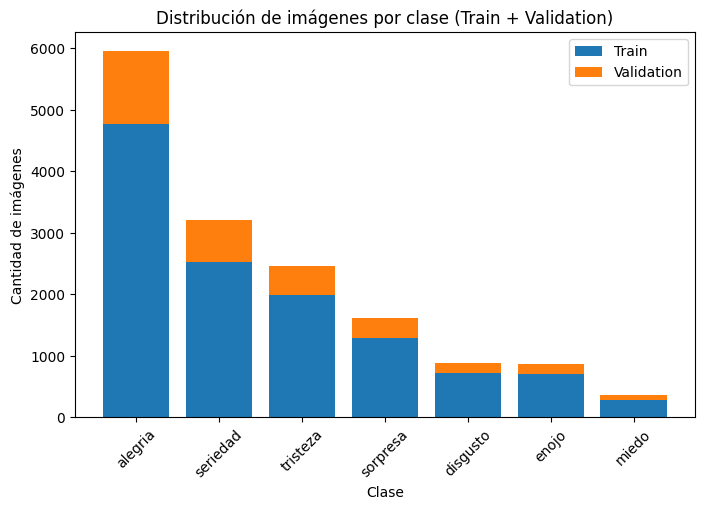

In [23]:
df_counts_sorted = df_counts.sort_values("total", ascending=False)

plt.figure(figsize=(8,5))
plt.bar(df_counts_sorted["class"], df_counts_sorted["train"], label="Train")
plt.bar(df_counts_sorted["class"], df_counts_sorted["val"],
        bottom=df_counts_sorted["train"], label="Validation")
plt.title("Distribución de imágenes por clase (Train + Validation)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Tras aplicar el preprocesamiento definido, la distribución de imágenes por clase en el conjunto de entrenamiento sigue siendo **muy desbalanceada**.  
La clase *alegría* cuenta con 6000 imágenes, mientras que la clase *miedo* solo dispone de 355, lo que representa una diferencia de casi **17×** entre ambas.

Para mitigar este problema y evitar que el modelo se sesgue hacia las clases mayoritarias, se utilizará la **WeightedRandomSampler** en el `DataLoader` de entrenamiento.  
De esta forma, cada batch se construirá muestreando las clases de forma balanceada según su frecuencia relativa, aumentando la probabilidad de aparición de las clases minoritarias.

In [24]:
BATCH_SIZE = 64
NUM_WORKERS = 2

# 1) Conteo por clase en TRAIN
y_train = [label for _, label in train_ds.samples]
cnt = Counter(y_train)

# 2) Pesos inversos a la frecuencia (clase rara = mayor peso)
class_weights = torch.tensor([1.0 / cnt[i] for i in range(len(cnt))], dtype=torch.float)

# 3) Peso por muestra según su clase
sample_weights = torch.tensor([class_weights[y] for y in y_train], dtype=torch.float)

# 4) Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # mismo tamaño que el dataset
    replacement=True                  # permite re-muestreo para balancear
)

# 5) DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Pesos por clase
print("class_weights:", {train_ds.classes[i]: float(class_weights[i]) for i in range(len(class_weights))})

class_weights: {'alegria': 0.00020955574291292578, 'disgusto': 0.0013947001425549388, 'enojo': 0.0014184396713972092, 'miedo': 0.0035587188322097063, 'seriedad': 0.00039619652670808136, 'sorpresa': 0.0007751937955617905, 'tristeza': 0.0005045408615842462}


Se utilizó **WeightedRandomSampler** para asignar un peso inverso a la frecuencia de cada clase.  
Así, las clases minoritarias (*miedo*, 0.00355) tienen mayor probabilidad de aparecer en cada batch que las mayoritarias (*alegría*, 0.00021), equilibrando el entrenamiento sin modificar la distribución del conjunto de validación.

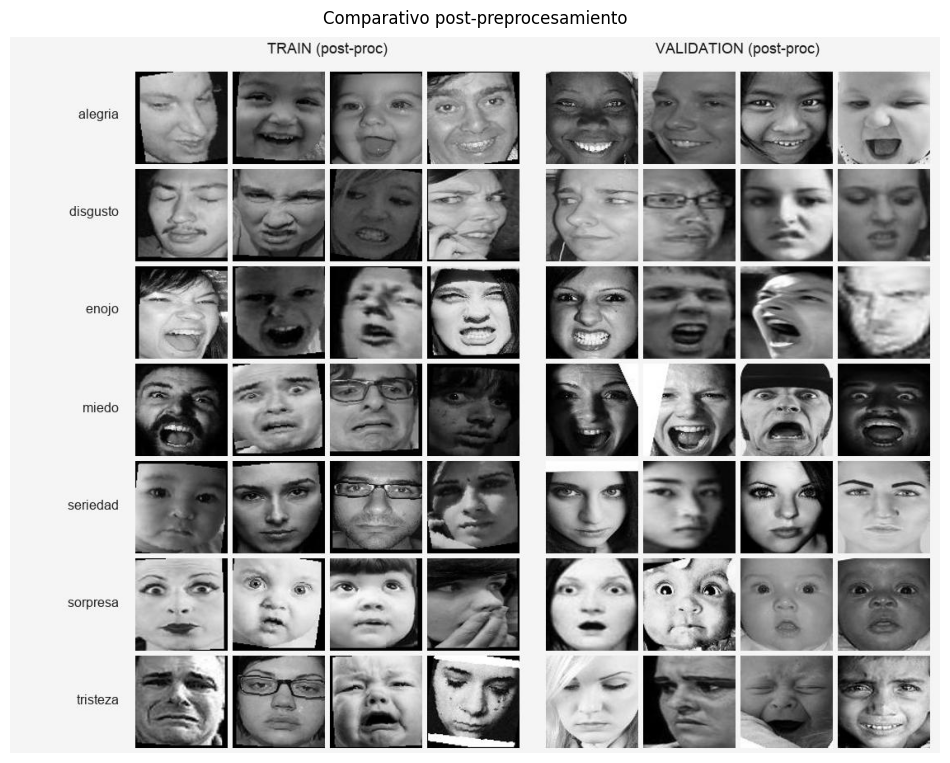

In [25]:
import torch, random, os
from PIL import Image, ImageOps, ImageDraw, ImageFont
import numpy as np

# Para que el aug sea más reproducible en la demo:
torch.manual_seed(42); random.seed(42)

# "des-normalizar" (para visualizar)
def unnormalize(img_tensor, mean, std):
    # img: [C,H,W], mean/std listas
    mean_t = torch.tensor(mean, device=img_tensor.device).view(-1,1,1)
    std_t  = torch.tensor(std,  device=img_tensor.device).view(-1,1,1)
    return img_tensor * std_t + mean_t  # vuelve a [0,1] aprox

def get_text_size(draw, text, font):
    try:
        bbox = draw.textbbox((0,0), text, font=font)
        return bbox[2]-bbox[0], bbox[3]-bbox[1]
    except AttributeError:
        return draw.textsize(text, font=font)

def build_mosaic_from_datasets(
    train_ds, val_ds, n_per_class=4, thumb=112,
    out_path="mosaic_train_val_postproc.jpg",
    margin=6, label_w=140, header_h=36,
    bg_color=(245,245,245), text_color=(30,30,30),
    mean=None, std=None
):
    classes = train_ds.classes
    # Mapear clase -> indices en cada dataset (para extraer ya con transforms)
    train_idx_by_class = {i: [] for i in range(len(classes))}
    val_idx_by_class   = {i: [] for i in range(len(classes))}
    for i, (_, y) in enumerate(train_ds.samples):
        train_idx_by_class[y].append(i)
    for i, (_, y) in enumerate(val_ds.samples):
        val_idx_by_class[y].append(i)

    # Canvas
    cols_each = n_per_class
    gap_between_panels = 20
    panel_w = cols_each * thumb + (cols_each + 1) * margin
    rows = len(classes)
    H = header_h + rows * thumb + (rows + 1) * margin
    W = label_w + margin + panel_w + gap_between_panels + panel_w + margin

    canvas = Image.new("RGB", (W, H), bg_color)
    draw = ImageDraw.Draw(canvas)
    try:
        font = ImageFont.truetype("Arial.ttf", 16)
        font_bold = ImageFont.truetype("Arial.ttf", 18)
    except:
        font = ImageFont.load_default()
        font_bold = ImageFont.load_default()

    def center_text_x(x0, x1, text, font):
        tw, _ = get_text_size(draw, text, font)
        return x0 + (x1 - x0 - tw)//2

    train_x0 = label_w + margin
    train_x1 = train_x0 + panel_w
    val_x0   = train_x1 + gap_between_panels
    val_x1   = val_x0 + panel_w

    draw.text((center_text_x(train_x0, train_x1, "TRAIN (post-proc)", font_bold), margin//2),
              "TRAIN (post-proc)", fill=text_color, font=font_bold)
    draw.text((center_text_x(val_x0, val_x1, "VALIDATION (post-proc)", font_bold), margin//2),
              "VALIDATION (post-proc)", fill=text_color, font=font_bold)

    # Para obtener muestras aplicando transforms del dataset
    def get_tensor_from_ds(ds, idx):
        x, _ = ds[idx]              # aplica transform (incluye ToTensor y Normalize)
        if mean is not None and std is not None:
            x = unnormalize(x, mean, std).clamp(0,1)
        # convertir a PIL
        np_img = (x.permute(1,2,0).cpu().numpy()*255).astype(np.uint8)  # [H,W,C]
        # si es 1 canal, convertir a RGB para pegar
        if np_img.shape[2] == 1:
            np_img = np.repeat(np_img, 3, axis=2)
        return Image.fromarray(np_img)

    def paste_strip(ds, idxs, start_x, y, cols):
        x = start_x + margin
        picks = idxs
        if len(picks) == 0:
            return
        if len(picks) < cols:
            picks = picks + random.choices(picks, k=cols - len(picks))
        for i in picks[:cols]:
            try:
                tile = get_tensor_from_ds(ds, i)
                tile = ImageOps.fit(tile, (thumb, thumb))
                canvas.paste(tile, (x, y))
            except Exception:
                pass
            x += thumb + margin

    y = header_h
    for cls_id, cls_name in enumerate(classes):
        # etiqueta fila
        tw, th = get_text_size(draw, cls_name, font)
        draw.text((max(0, label_w - tw - 8), y + (thumb - th)//2),
                  cls_name, fill=text_color, font=font)

        # indices por clase
        tr_idxs = train_idx_by_class.get(cls_id, [])
        vl_idxs = val_idx_by_class.get(cls_id, [])

        # samplear n_per_class por lado
        tr_sample = random.sample(tr_idxs, min(n_per_class, len(tr_idxs))) if tr_idxs else []
        vl_sample = random.sample(vl_idxs, min(n_per_class, len(vl_idxs))) if vl_idxs else []

        paste_strip(train_ds, tr_sample, train_x0, y + margin, cols_each)
        paste_strip(val_ds,   vl_sample, val_x0,   y + margin, cols_each)

        y += thumb + margin

    canvas.save(out_path)
    return out_path

# mean/std ya calculados antes para GRAYSCALE (ej: lists de 1 valor)
mosaic_path = build_mosaic_from_datasets(
    train_ds, val_ds,
    n_per_class=4, thumb=112,
    out_path="mosaic_train_val_postproc.jpg",
    mean=mean.tolist(), std=std.tolist()
)

from PIL import Image
import matplotlib.pyplot as plt
if mosaic_path and os.path.exists(mosaic_path):
    img = Image.open(mosaic_path)
    plt.figure(figsize=(12,10))
    plt.imshow(img); plt.axis('off'); plt.title("Comparativo post‑preprocesamiento", pad=10)
    plt.show()

Tras el preprocesamiento, todas las imágenes se encuentran **normalizadas en escala de grises**, con tamaño y encuadre consistentes.  
El *data augmentation* aplicado genera variaciones moderadas en orientación, posición y reflejo, lo que incrementa la diversidad sin alterar la coherencia visual.  
Esto permite que el modelo aprenda patrones más robustos y generalizables, reduciendo la dependencia de características específicas del conjunto original.

## 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando dispositivo:", device)

Usando dispositivo: cpu


In [27]:
dataloader = {
    "train": train_loader,
    "test": val_loader
}

### Diseño de la arquitectura

- **Entrada**: imágenes 1×100×100 en escala de grises → menos parámetros y sin ruido de color.  
- **Extracción de rasgos**: 3 bloques `Conv(3×3) → ReLU → MaxPool(2×2)` con canales **32→64→128**, duplicando canales al bajar resolución (100→50→25→12) para captar bordes, contornos y texturas faciales.  
- **Pooling final**: `MaxPool2d(2×2)` extra tras el último bloque convolucional, reduciendo de 128×12×12 a 128×6×6 → menos parámetros en la capa fully connected y mejor generalización.
- **Regularización**: `Dropout2d` tras `conv1` y `conv2`, y `Dropout(0.3)` en el head para evitar sobreajuste.  
- **Head**: `Flatten → Linear(...→128) → ReLU → Linear(128→7)`.  
- **Entrenamiento**: `CrossEntropyLoss` con `WeightedRandomSampler` (balanceo en batches), `AdamW(lr=3e-4, weight_decay=1e-4)`, `ReduceLROnPlateau` y `EarlyStopping(paciencia=7)`.  
- **Ventajas**: arquitectura simple pero capaz, preparada para datos desbalanceados y variaciones leves gracias al balanceo, *dropout* y *augmentation*.

In [28]:
def conv_block(c_in, c_out, k=3, p='same', s=1, pk=2):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, kernel_size=k, padding=p, stride=s, bias=True),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=pk)
    )

class CNN(nn.Module):
    def __init__(self, n_channels=1, n_outputs=7, input_hw=(100,100), p_drop2d=0.3, p_drop=0.3):
        super().__init__()
        H, W = input_hw

        # Bloques conv (sin BN)
        self.conv1 = conv_block(n_channels, 32, k=3, p='same', s=1, pk=2)   # 1x100x100 -> 32x50x50
        self.conv1_out = None
        self.drop2d = nn.Dropout2d(p=p_drop2d)
        self.conv2 = conv_block(32, 64, k=3, p='same', s=1, pk=2)           # 32x50x50 -> 64x25x25
        self.conv2_out = None
        self.conv3 = conv_block(64, 128, k=3, p='same', s=1, pk=2)           # 64x25x25 -> 128x12x12

        # Pooling final adicional
        self.final_pool = nn.MaxPool2d(kernel_size=2)                       # 128x12x12 -> 128x6x6

        # Calcular dim de entrada
        with torch.no_grad():
            dummy = torch.zeros(1, n_channels, H, W)
            f = self._forward_feats(dummy)                # [1, 128, 12, 12]
            self._feat_dim = f.numel()                    # 128*12*12

        # Head FC con Dropout
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=p_drop),
            nn.Linear(self._feat_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)                     # logits
        )

        # ---- Info útil
        print('Red creada\narquitectura:')
        print(self)
        print('Dims features a FC:', self._feat_dim)
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Parámetros entrenables:', total_params)

    # Forward solo de las features convolucionales
    def _forward_feats(self, x):
        self.conv1_out = self.drop2d(self.conv1(x))               # [B, 32, 50, 50]
        self.conv2_out = self.drop2d(self.conv2(self.conv1_out))  # [B, 64, 25, 25]
        y = self.conv3(self.conv2_out)                            # [B, 128, 12, 12]
        y = self.final_pool(y)                                    # [B, 128, 6, 6]
        return y

    # Forward completo
    def forward(self, x):
        y = self._forward_feats(x)    # [B, 128, 6, 6]
        y = self.classifier(y)        # [B, n_outputs]
        return y

In [29]:
model = CNN()

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop2d): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (final_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=4608, out_features=128, bias=True)
    (3): ReLU(inplace=True)

In [30]:
torchinfo.summary(model, input_size=(64, 1, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 7]                   --
├─Sequential: 1-1                        [64, 32, 50, 50]          --
│    └─Conv2d: 2-1                       [64, 32, 100, 100]        320
│    └─ReLU: 2-2                         [64, 32, 100, 100]        --
│    └─MaxPool2d: 2-3                    [64, 32, 50, 50]          --
├─Dropout2d: 1-2                         [64, 32, 50, 50]          --
├─Sequential: 1-3                        [64, 64, 25, 25]          --
│    └─Conv2d: 2-4                       [64, 64, 50, 50]          18,496
│    └─ReLU: 2-5                         [64, 64, 50, 50]          --
│    └─MaxPool2d: 2-6                    [64, 64, 25, 25]          --
├─Dropout2d: 1-4                         [64, 64, 25, 25]          --
├─Sequential: 1-5                        [64, 128, 12, 12]         --
│    └─Conv2d: 2-7                       [64, 128, 25, 25]         73,856
│    └

In [31]:
def fit(model, dataloader, epochs=15, patience=7):
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    best_val_loss = float('inf')
    patience_counter = 0

    # Historial
    epoch_t_loss, epoch_v_loss = [], []
    epoch_t_acc, epoch_v_acc = [], []
    epoch_t_f1, epoch_v_f1 = [], [] 

    for epoch in range(1, epochs+1):
        # ------------------- Entrenamiento -------------------
        model.train()
        train_loss, correct, total = 0, 0, 0
        y_true_train, y_pred_train = [], [] 
        bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs} [Train]")
        for X, y in bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y.size(0)
            preds = torch.argmax(y_hat, axis=1)
            correct += (y == preds).sum().item()
            total += y.size(0)

            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

            bar.set_postfix(loss=loss.item())

        train_loss /= total
        train_acc = correct / total
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')

        epoch_t_loss.append(train_loss)
        epoch_t_acc.append(train_acc)
        epoch_t_f1.append(train_f1)

        # ------------------- Validación -------------------
        model.eval()
        val_loss, correct, total = 0, 0, 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for X, y in dataloader['test']:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)

                val_loss += loss.item() * y.size(0)
                preds = torch.argmax(y_hat, axis=1)
                correct += (y == preds).sum().item()
                total += y.size(0)

                y_true_val.extend(y.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())

        val_loss /= total
        val_acc = correct / total
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')

        epoch_v_loss.append(val_loss)
        epoch_v_acc.append(val_acc)
        epoch_v_f1.append(val_f1)

        scheduler.step(val_loss)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping activado")
                break

    return epoch_t_loss, epoch_t_acc, epoch_t_f1, epoch_v_loss, epoch_v_acc, epoch_v_f1

In [32]:
epoch_t_loss, epoch_t_acc, epoch_t_f1, epoch_v_loss, epoch_v_acc, epoch_v_f1 = fit(model, dataloader, epochs=100, patience=7)

Epoch 1/100 [Train]: 100%|██████████| 192/192 [01:37<00:00,  1.98it/s, loss=1.58]


Epoch 1/100 | Train Loss: 1.8317 | Val Loss: 1.7843 | Train Acc: 0.2478 | Val Acc: 0.2973 | Train F1: 0.2399 | Val F1: 0.3206


Epoch 2/100 [Train]: 100%|██████████| 192/192 [01:36<00:00,  1.99it/s, loss=1.7] 


Epoch 2/100 | Train Loss: 1.6257 | Val Loss: 1.5059 | Train Acc: 0.3759 | Val Acc: 0.4658 | Train F1: 0.3714 | Val F1: 0.4829


Epoch 3/100 [Train]: 100%|██████████| 192/192 [01:33<00:00,  2.06it/s, loss=1.42]


Epoch 3/100 | Train Loss: 1.4891 | Val Loss: 1.3137 | Train Acc: 0.4454 | Val Acc: 0.5362 | Train F1: 0.4407 | Val F1: 0.5542


Epoch 4/100 [Train]: 100%|██████████| 192/192 [01:36<00:00,  1.99it/s, loss=1.37]


Epoch 4/100 | Train Loss: 1.4125 | Val Loss: 1.3048 | Train Acc: 0.4772 | Val Acc: 0.5310 | Train F1: 0.4740 | Val F1: 0.5698


Epoch 5/100 [Train]: 100%|██████████| 192/192 [01:34<00:00,  2.03it/s, loss=1.03]


Epoch 5/100 | Train Loss: 1.3292 | Val Loss: 1.2600 | Train Acc: 0.5056 | Val Acc: 0.5417 | Train F1: 0.5029 | Val F1: 0.5798


Epoch 6/100 [Train]: 100%|██████████| 192/192 [01:38<00:00,  1.96it/s, loss=1.14]


Epoch 6/100 | Train Loss: 1.2798 | Val Loss: 1.1815 | Train Acc: 0.5313 | Val Acc: 0.5662 | Train F1: 0.5304 | Val F1: 0.5894


Epoch 7/100 [Train]: 100%|██████████| 192/192 [01:36<00:00,  1.98it/s, loss=1.1]  


Epoch 7/100 | Train Loss: 1.2266 | Val Loss: 1.0543 | Train Acc: 0.5471 | Val Acc: 0.6356 | Train F1: 0.5456 | Val F1: 0.6526


Epoch 8/100 [Train]: 100%|██████████| 192/192 [01:37<00:00,  1.96it/s, loss=1.31] 


Epoch 8/100 | Train Loss: 1.1884 | Val Loss: 0.9920 | Train Acc: 0.5651 | Val Acc: 0.6444 | Train F1: 0.5648 | Val F1: 0.6590


Epoch 9/100 [Train]: 100%|██████████| 192/192 [01:37<00:00,  1.97it/s, loss=1.22] 


Epoch 9/100 | Train Loss: 1.1498 | Val Loss: 0.9978 | Train Acc: 0.5823 | Val Acc: 0.6281 | Train F1: 0.5819 | Val F1: 0.6498


Epoch 10/100 [Train]: 100%|██████████| 192/192 [01:29<00:00,  2.15it/s, loss=1]    


Epoch 10/100 | Train Loss: 1.1202 | Val Loss: 1.0616 | Train Acc: 0.5919 | Val Acc: 0.6118 | Train F1: 0.5923 | Val F1: 0.6396


Epoch 11/100 [Train]: 100%|██████████| 192/192 [01:31<00:00,  2.09it/s, loss=1]    


Epoch 11/100 | Train Loss: 1.1068 | Val Loss: 0.9660 | Train Acc: 0.6000 | Val Acc: 0.6574 | Train F1: 0.6001 | Val F1: 0.6715


Epoch 12/100 [Train]: 100%|██████████| 192/192 [01:30<00:00,  2.12it/s, loss=1.05] 


Epoch 12/100 | Train Loss: 1.0551 | Val Loss: 0.9611 | Train Acc: 0.6136 | Val Acc: 0.6617 | Train F1: 0.6140 | Val F1: 0.6805


Epoch 13/100 [Train]: 100%|██████████| 192/192 [01:40<00:00,  1.91it/s, loss=1.08] 


Epoch 13/100 | Train Loss: 1.0441 | Val Loss: 0.8829 | Train Acc: 0.6160 | Val Acc: 0.6858 | Train F1: 0.6161 | Val F1: 0.7024


Epoch 14/100 [Train]: 100%|██████████| 192/192 [01:44<00:00,  1.84it/s, loss=1.14] 


Epoch 14/100 | Train Loss: 1.0215 | Val Loss: 0.8936 | Train Acc: 0.6298 | Val Acc: 0.6721 | Train F1: 0.6306 | Val F1: 0.6906


Epoch 15/100 [Train]: 100%|██████████| 192/192 [01:42<00:00,  1.87it/s, loss=0.791]


Epoch 15/100 | Train Loss: 0.9960 | Val Loss: 0.9690 | Train Acc: 0.6357 | Val Acc: 0.6421 | Train F1: 0.6365 | Val F1: 0.6674


Epoch 16/100 [Train]: 100%|██████████| 192/192 [01:43<00:00,  1.86it/s, loss=1.1]  


Epoch 16/100 | Train Loss: 0.9955 | Val Loss: 0.8478 | Train Acc: 0.6352 | Val Acc: 0.6894 | Train F1: 0.6357 | Val F1: 0.7079


Epoch 17/100 [Train]: 100%|██████████| 192/192 [01:41<00:00,  1.88it/s, loss=1.1]  


Epoch 17/100 | Train Loss: 0.9771 | Val Loss: 0.8440 | Train Acc: 0.6439 | Val Acc: 0.6890 | Train F1: 0.6444 | Val F1: 0.7054


Epoch 18/100 [Train]: 100%|██████████| 192/192 [01:59<00:00,  1.61it/s, loss=1.06] 


Epoch 18/100 | Train Loss: 0.9449 | Val Loss: 0.8484 | Train Acc: 0.6516 | Val Acc: 0.6952 | Train F1: 0.6523 | Val F1: 0.7095


Epoch 19/100 [Train]: 100%|██████████| 192/192 [01:41<00:00,  1.89it/s, loss=0.648]


Epoch 19/100 | Train Loss: 0.9314 | Val Loss: 0.8765 | Train Acc: 0.6585 | Val Acc: 0.6806 | Train F1: 0.6592 | Val F1: 0.7051


Epoch 20/100 [Train]: 100%|██████████| 192/192 [01:46<00:00,  1.80it/s, loss=0.8]  


Epoch 20/100 | Train Loss: 0.9268 | Val Loss: 0.8798 | Train Acc: 0.6607 | Val Acc: 0.6747 | Train F1: 0.6614 | Val F1: 0.6963


Epoch 21/100 [Train]: 100%|██████████| 192/192 [01:44<00:00,  1.84it/s, loss=1.16] 


Epoch 21/100 | Train Loss: 0.9034 | Val Loss: 0.8579 | Train Acc: 0.6693 | Val Acc: 0.6741 | Train F1: 0.6702 | Val F1: 0.6928


Epoch 22/100 [Train]: 100%|██████████| 192/192 [01:40<00:00,  1.91it/s, loss=1.09] 


Epoch 22/100 | Train Loss: 0.8815 | Val Loss: 0.7852 | Train Acc: 0.6839 | Val Acc: 0.7089 | Train F1: 0.6846 | Val F1: 0.7212


Epoch 23/100 [Train]: 100%|██████████| 192/192 [01:41<00:00,  1.90it/s, loss=0.847]


Epoch 23/100 | Train Loss: 0.8688 | Val Loss: 0.7971 | Train Acc: 0.6801 | Val Acc: 0.6995 | Train F1: 0.6811 | Val F1: 0.7115


Epoch 24/100 [Train]: 100%|██████████| 192/192 [01:43<00:00,  1.86it/s, loss=0.871]


Epoch 24/100 | Train Loss: 0.8298 | Val Loss: 0.7716 | Train Acc: 0.6982 | Val Acc: 0.7154 | Train F1: 0.6989 | Val F1: 0.7294


Epoch 25/100 [Train]: 100%|██████████| 192/192 [01:42<00:00,  1.88it/s, loss=0.717]


Epoch 25/100 | Train Loss: 0.8484 | Val Loss: 0.7456 | Train Acc: 0.6899 | Val Acc: 0.7249 | Train F1: 0.6905 | Val F1: 0.7346


Epoch 26/100 [Train]: 100%|██████████| 192/192 [01:40<00:00,  1.90it/s, loss=0.897]


Epoch 26/100 | Train Loss: 0.8353 | Val Loss: 0.7903 | Train Acc: 0.6966 | Val Acc: 0.7057 | Train F1: 0.6973 | Val F1: 0.7221


Epoch 27/100 [Train]: 100%|██████████| 192/192 [01:40<00:00,  1.90it/s, loss=0.591]


Epoch 27/100 | Train Loss: 0.8149 | Val Loss: 0.7757 | Train Acc: 0.7027 | Val Acc: 0.7151 | Train F1: 0.7031 | Val F1: 0.7300


Epoch 28/100 [Train]: 100%|██████████| 192/192 [01:39<00:00,  1.92it/s, loss=0.7]  


Epoch 28/100 | Train Loss: 0.8146 | Val Loss: 0.7325 | Train Acc: 0.7046 | Val Acc: 0.7334 | Train F1: 0.7050 | Val F1: 0.7448


Epoch 29/100 [Train]: 100%|██████████| 192/192 [01:43<00:00,  1.85it/s, loss=0.815]


Epoch 29/100 | Train Loss: 0.8100 | Val Loss: 0.7663 | Train Acc: 0.7064 | Val Acc: 0.7138 | Train F1: 0.7069 | Val F1: 0.7275


Epoch 30/100 [Train]: 100%|██████████| 192/192 [01:43<00:00,  1.86it/s, loss=0.833]


Epoch 30/100 | Train Loss: 0.7826 | Val Loss: 0.7484 | Train Acc: 0.7184 | Val Acc: 0.7197 | Train F1: 0.7191 | Val F1: 0.7326


Epoch 31/100 [Train]: 100%|██████████| 192/192 [01:40<00:00,  1.91it/s, loss=0.649]


Epoch 31/100 | Train Loss: 0.8028 | Val Loss: 0.7239 | Train Acc: 0.7070 | Val Acc: 0.7304 | Train F1: 0.7077 | Val F1: 0.7413


Epoch 32/100 [Train]: 100%|██████████| 192/192 [01:39<00:00,  1.93it/s, loss=1.05] 


Epoch 32/100 | Train Loss: 0.7904 | Val Loss: 0.7481 | Train Acc: 0.7152 | Val Acc: 0.7243 | Train F1: 0.7158 | Val F1: 0.7395


Epoch 33/100 [Train]: 100%|██████████| 192/192 [01:38<00:00,  1.95it/s, loss=0.529]


Epoch 33/100 | Train Loss: 0.7760 | Val Loss: 0.7252 | Train Acc: 0.7208 | Val Acc: 0.7331 | Train F1: 0.7214 | Val F1: 0.7429


Epoch 34/100 [Train]: 100%|██████████| 192/192 [01:39<00:00,  1.93it/s, loss=0.737]


Epoch 34/100 | Train Loss: 0.7686 | Val Loss: 0.7481 | Train Acc: 0.7193 | Val Acc: 0.7278 | Train F1: 0.7201 | Val F1: 0.7421


Epoch 35/100 [Train]: 100%|██████████| 192/192 [01:41<00:00,  1.89it/s, loss=0.704]


Epoch 35/100 | Train Loss: 0.7469 | Val Loss: 0.7319 | Train Acc: 0.7247 | Val Acc: 0.7379 | Train F1: 0.7256 | Val F1: 0.7474


Epoch 36/100 [Train]: 100%|██████████| 192/192 [01:41<00:00,  1.90it/s, loss=0.822]


Epoch 36/100 | Train Loss: 0.7318 | Val Loss: 0.7064 | Train Acc: 0.7343 | Val Acc: 0.7438 | Train F1: 0.7348 | Val F1: 0.7518


Epoch 37/100 [Train]: 100%|██████████| 192/192 [01:42<00:00,  1.88it/s, loss=0.721]


Epoch 37/100 | Train Loss: 0.7418 | Val Loss: 0.7202 | Train Acc: 0.7281 | Val Acc: 0.7350 | Train F1: 0.7289 | Val F1: 0.7461


Epoch 38/100 [Train]: 100%|██████████| 192/192 [01:39<00:00,  1.93it/s, loss=0.552]


Epoch 38/100 | Train Loss: 0.7452 | Val Loss: 0.7185 | Train Acc: 0.7268 | Val Acc: 0.7360 | Train F1: 0.7276 | Val F1: 0.7485


Epoch 39/100 [Train]: 100%|██████████| 192/192 [01:45<00:00,  1.82it/s, loss=0.953]


Epoch 39/100 | Train Loss: 0.7343 | Val Loss: 0.7180 | Train Acc: 0.7314 | Val Acc: 0.7357 | Train F1: 0.7322 | Val F1: 0.7469


Epoch 40/100 [Train]: 100%|██████████| 192/192 [01:42<00:00,  1.88it/s, loss=0.723]


Epoch 40/100 | Train Loss: 0.7156 | Val Loss: 0.7225 | Train Acc: 0.7390 | Val Acc: 0.7363 | Train F1: 0.7395 | Val F1: 0.7486


Epoch 41/100 [Train]: 100%|██████████| 192/192 [01:43<00:00,  1.86it/s, loss=0.782]


Epoch 41/100 | Train Loss: 0.7297 | Val Loss: 0.7253 | Train Acc: 0.7372 | Val Acc: 0.7344 | Train F1: 0.7379 | Val F1: 0.7478


Epoch 42/100 [Train]: 100%|██████████| 192/192 [01:39<00:00,  1.93it/s, loss=0.767]


Epoch 42/100 | Train Loss: 0.7200 | Val Loss: 0.7288 | Train Acc: 0.7380 | Val Acc: 0.7295 | Train F1: 0.7383 | Val F1: 0.7439


Epoch 43/100 [Train]: 100%|██████████| 192/192 [01:40<00:00,  1.91it/s, loss=0.602]


Epoch 43/100 | Train Loss: 0.7221 | Val Loss: 0.7083 | Train Acc: 0.7308 | Val Acc: 0.7448 | Train F1: 0.7314 | Val F1: 0.7553
Early stopping activado


## 3. Evaluación del Modelo (2.5 puntos)

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.


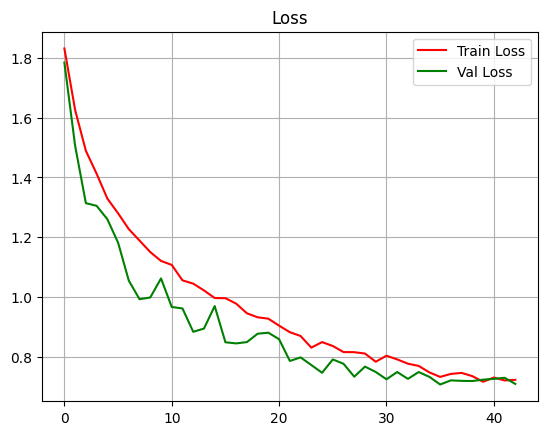

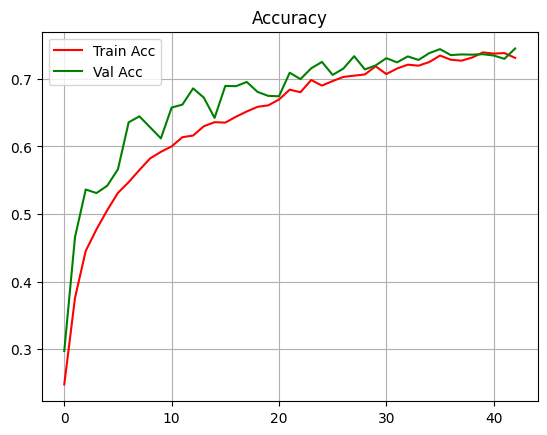

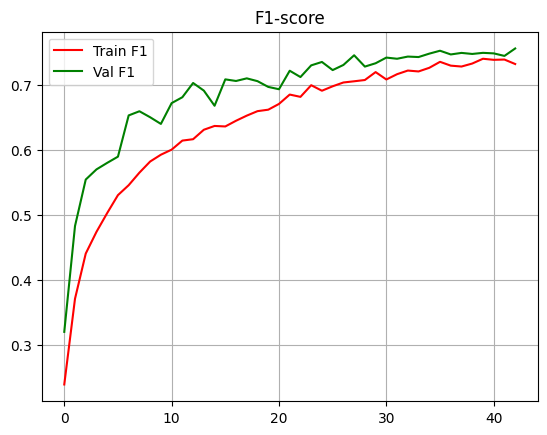

In [33]:
# ------------------- Gráficos -------------------
plt.figure()
plt.plot(epoch_t_loss, 'r', label='Train Loss')
plt.plot(epoch_v_loss, 'g', label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epoch_t_acc, 'r', label='Train Acc')
plt.plot(epoch_v_acc, 'g', label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epoch_t_f1, 'r', label='Train F1')
plt.plot(epoch_v_f1, 'g', label='Val F1')
plt.title('F1-score')
plt.legend()
plt.grid()
plt.show()

In [34]:
def evaluate_model(model, dataloader):
    class_names = dataloader.dataset.classes
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Métricas ---
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")

    # --- Classification report ---
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # --- Matriz de confusión ---
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title("Matriz de Confusión Absoluta")
    axes[0].set_xlabel("Predicción")
    axes[0].set_ylabel("Etiqueta real")

    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1], xticklabels=class_names, yticklabels=class_names)
    axes[1].set_title("Matriz de Confusión Normalizada")
    axes[1].set_xlabel("Predicción")
    axes[1].set_ylabel("Etiqueta real")

    plt.tight_layout()
    plt.show()

    return acc, f1

Accuracy: 0.7448
F1-score (weighted): 0.7553

Classification Report:
              precision    recall  f1-score   support

     alegria       0.94      0.82      0.88      1185
    disgusto       0.35      0.54      0.43       160
       enojo       0.57      0.80      0.66       162
       miedo       0.39      0.64      0.48        74
    seriedad       0.75      0.69      0.72       680
    sorpresa       0.78      0.75      0.77       329
    tristeza       0.67      0.70      0.68       478

    accuracy                           0.74      3068
   macro avg       0.64      0.70      0.66      3068
weighted avg       0.78      0.74      0.76      3068



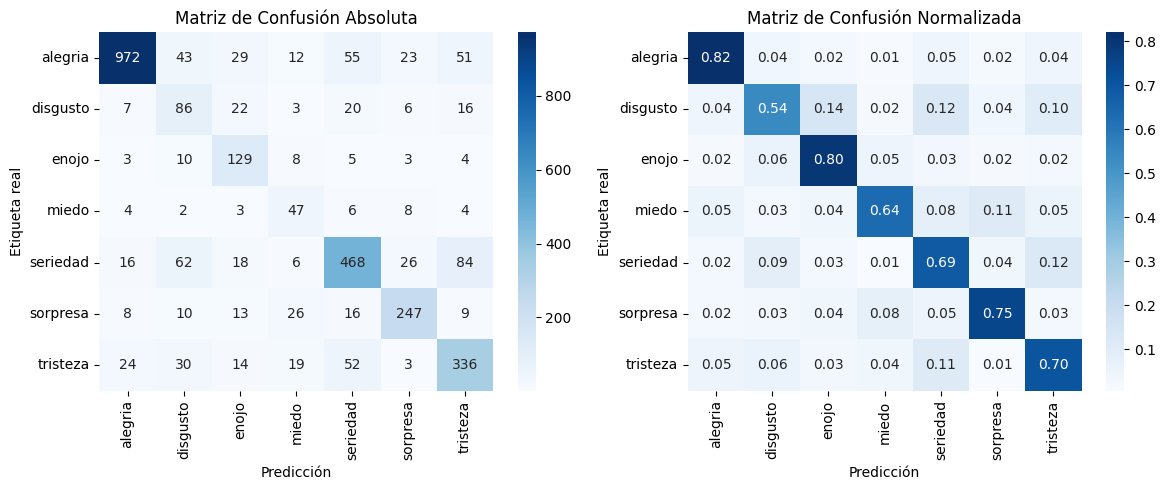

(0.7447848761408083, 0.7552810512135232)

In [35]:
evaluate_model(model, dataloader['test'])

El modelo logró un **Accuracy** de **74.48%** y un **F1-score ponderado** de **75.53%** en el conjunto de validación, mostrando un desempeño general sólido en la clasificación de las distintas emociones.

En las curvas de entrenamiento se observa una mejora continua en *loss*, *accuracy* y *F1-score* para entrenamiento y validación, sin signos evidentes de sobreajuste, ya que las métricas en validación se mantienen cercanas a las de entrenamiento.

El **classification report** indica que las clases más representadas, como *alegría*, *seriedad* y *sorpresa*, presentan los mejores desempeños en precisión y recall. Sin embargo, clases minoritarias como *miedo* y *disgusto* muestran métricas más bajas, lo que sugiere que el modelo podría beneficiarse de técnicas para balancear las clases.

La **matriz de confusión** evidencia que la mayoría de las predicciones son correctas, especialmente en *alegría* (82% de aciertos), *enojo* (80%), *sorpresa* (75%) y *tristeza* (70%). No obstante, existen confusiones notables entre clases con emociones similares, como *seriedad* y *tristeza*, o *disgusto* y *miedo*.

En resumen, el modelo presenta un rendimiento satisfactorio, pero podría optimizarse para mejorar el reconocimiento de clases menos frecuentes y reducir confusiones entre emociones cercanas.

 ## 4. Prueba de Imágenes Nuevas (1 punto)
Subir al menos 5 imágenes personales de cualquier relación de aspecto (pueden usar fotos del rostro de ustedes, rostros de personas generadas por IA o imágenes stock de internet), que no formen parte del dataset de entrenamiento ni de validación.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo pre-procesamiento que se usó para el dataset durante el entrenamiento del modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Redactar conclusiones preliminares

In [36]:
# Cargar los mejores pesos
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop2d): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (final_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=4608, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_featu

 ## 5. Prueba de Imágenes Nuevas con Pre-procesamiento Adicional (1 punto)
Las 5 imágenes del punto 4, ahora serán pasadas y recortadas por un algoritmo de detección de rostros. Usen el siguiente código para realizar un pre-procesamiento inicial de la imagen y ya luego aplican el pre-procesamiento que usaron al momento de entrenar el modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:
  - La imagen original
  - La imagen recortada por el algoritmo
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Comparar los resultados con el punto 4 y redactar conclusiones finales.

NOTA: Pueden adaptar el código según crean conveniente para obtener mejores resultados.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image_path = ""

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)

image_with_box = image.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

cropped_face_rgb = None
if len(faces) > 0:
    (x, y, w, h) = faces[0]
    center_x, center_y = x + w // 2, y + h // 2
    side = max(w, h)
    half_side = side // 2

    x1 = max(center_x - half_side, 0)
    y1 = max(center_y - half_side, 0)
    x2 = min(center_x + half_side, image.shape[1])
    y2 = min(center_y + half_side, image.shape[0])

    cropped_face = image[y1:y2, x1:x2]
    cropped_face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

image_with_box_rgb = cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_with_box_rgb)
ax[0].set_title("Detección")
ax[0].axis('off')

if cropped_face_rgb is not None:
    ax[1].imshow(cropped_face_rgb)
    ax[1].set_title("Rostro recortado (relación aspecto 1:1)")
    ax[1].axis('off')
else:
    ax[1].text(0.5, 0.5, 'No se detectó rostro', horizontalalignment='center', verticalalignment='center')
    ax[1].axis('off')

plt.tight_layout()
plt.show()
